# "Fingers Count using ResNet"
> "count fingers & distinguish between left and right hand"

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [fastpages, jupyter]
- image: images/some_folder/your_image.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

## To build a model able to count fingers as well as distinguish between left and right hand.
* Dataset - https://www.kaggle.com/koryakinp/fingers<br>
* I have used **ResNet50** model and trained it with help of Tranfer learning approach using Keras.

### Importing Necessary Libraries


In [88]:
%tensorflow_version 2.x

import tensorflow.keras as keras
import tensorflow as tf
import os
from PIL import Image
import numpy as np
from numpy import asarray
from numpy import expand_dims
from numpy import load
from numpy import savez_compressed
import matplotlib.pyplot as plt
import os

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

%config Completer.use_jedi = False

#enter your directry path
dataset_dir = '/content/drive/MyDrive/ResNet Project/' 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.


### Load Data
* I already load all images and saved in "**fingers_train.npz**" file
* You can find 'fingers_train.npz' file [here](https://drive.google.com/file/d/1pFlrW-1AkCM7LuxfkhXlFNZ7PDaJsZdn/view?usp=sharing)

In [89]:
#load dataset
with load(dataset_dir + 'fingers_train.npz') as data:
  X_train, X_test, y_train, y_test = data['arr_0'],data['arr_1'],data['arr_2'],data['arr_3']

### Mapping of original labels with categorical variables<br>
**Notations**:<br>
3L = 3 fingers of left hand<br>
5R = 5 fingers of right hand

In [90]:
#mapping of original classes with categorical variable
label_dict = {}
for i in range(12):
  if i <=5:
    label_dict[i] = str(i)+'L'
    continue
  label_dict[i] = str(i-6)+'R'
for i in label_dict:
  print(f"{label_dict[i]} -> {i}")

0L -> 0
1L -> 1
2L -> 2
3L -> 3
4L -> 4
5L -> 5
0R -> 6
1R -> 7
2R -> 8
3R -> 9
4R -> 10
5R -> 11


### Exploring Datasets

Train Images:(18000, 128, 128, 3)
Test Images:(3600, 128, 128, 3)
y_train shape:(18000, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 18000 + 1) instead
  after removing the cwd from sys.path.


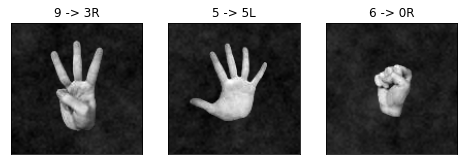

In [95]:
print(f"Train Images:{X_train.shape}")
print(f"Test Images:{X_test.shape}")
print(f"y_train shape:{y_train.shape}")
index = np.random.random_integers(0,18000,3)

fig,axes = plt.subplots(1,3,figsize = (8,6))
for ax,ind in zip(axes,index):
  img = array_to_img(X_train[ind])
  ax.imshow(img)
  ax.set_title(f"{y_train[ind][0]} -> {label_dict[y_train[ind][0]]}")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


### Preprocessing on images for ResNet50 model.<br>
Every Deep Learnig Model need input in required format. Keras Provide functions for each model, ResNet50's Preprocess function will do follwing tasks:


1.   The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling
2.   Y vector will be converted into one-hot-encodding format<br>
e.g. -  we have 12 ouput classes then,<br>
[2] -> [0,0,1,0,0,0,0,0,0,0,0,0]



In [96]:
def preprocess_data(x,y):
    x_p = keras.applications.resnet50.preprocess_input(x)
    y_p = keras.utils.to_categorical(y,12)
    return x_p,y_p

In [97]:
#data preprocessing
X_train,y_train, = preprocess_data(X_train,y_train)
X_test,y_test = preprocess_data(X_test,y_test)

### Load Resnet50 Model

**Parameters:**
*   include_top = By seeting this as **False** will allow feature extraction by removing the last dense layers 
*   weights = Here we will use weights of pretrained **"ImageNet"** model. This will reduce time & computation cost.
*   input_tensor = We need to set shape of Input Image. It is observed that ResNet50 is giving good accuracy on **(224,224)** shaped image.





In [98]:
#make a input tensor
input_tensor = keras.Input(shape=(224,224,3))

#make a ResNet model
resnet_model = keras.applications.ResNet50(include_top = False,weights='imagenet',input_tensor = input_tensor)

#resnet_model.summary()

94773248/94765736 [==============================] - 1s 0us/step


### Freezing Layers
* In order to train our model we does not need to train all weights! 
* We have to train only last layer as per our dataset. 
* So We have to freeze all previous layers' weights. 

In [ ]:
#layers of ResNet model
Layers = resnet_model.layers
print(f"Total layers = {len(Layers)}")

#Transfer Learning
#freeze all layers except last block(conv5)
for ind,each in enumerate(Layers):
    if "conv5" not in each.name:
        each.trainable = False

Total layers = 175


### Adding Custom Layers in  Keras Sequential model

Along With ResNet50 We Will add following Custom Layers:
1.   Lambda Layer : to convert Image into given size (224,224)
2.   Flatten() -> BatchNormalization()
3.   Dense(256,"relu") -> Dropout(0.5) -> BatchNormalization()
4.   Dense(128,"relu") -> Dropout(0.5) -> BatchNormalization()
5.   Dense(64,"relu") -> Dropout(0.5) -> BatchNormalization()
6.   Dense(12,"softmax") == output layer






In [ ]:
#initialize keras model
model = keras.Sequential()

#ResNet50 gives high accuracy on Image of Shape (224,224)
#resize each image to (224,224)
size = (224,224)

#create Lambda Layer to resize an image
model.add(keras.layers.Lambda(lambda image: tf.image.resize(image,(224,224))))

#add resnet_model (ResNet50)
model.add(resnet_model)

#add flatten layer
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())

#Add 3 Dense layers of sizes [256,128,64]
dense_neaurons = [256,128,64]
for size in dense_neaurons:
    
    #add dense layer
    model.add(keras.layers.Dense(size,activation='relu'))
    
    #add droput to avoid overfitting
    model.add(keras.layers.Dropout(0.5))
    
    #BatchNormaliztion
    model.add(keras.layers.BatchNormalization())

#add softmax layer with 12 output labels
model.add(keras.layers.Dense(12,activation='softmax'))

### Callbacks
In Keras, we can use callbacks in our model to perform certain  actions in the training such as weight saving

In [ ]:
#Callbacks.
check_point = keras.callbacks.ModelCheckpoint(filepath= dataset_dir+'fingers.h5',
                                             monitor='val_acc',
                                             mode='max',
                                             save_best_only=True)

### model.compile()
**Parameters:**
*   Optimization method = RMSprop
*   Learning rate: Now, We are using most of pretrained weights so we have to keep LR very samll



In [ ]:
model.compile(optimizer=keras.optimizers.RMSprop(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training

In [ ]:
history = model.fit(X_train,y_train,batch_size=32,epochs=6,verbose=1, validation_data = (X_test,y_test), callbacks=[check_point])
#print(hory)

Epoch 1/6
563/563 [==============================] - 128s 160ms/step - loss: 1.5634 - accuracy: 0.5134 - val_loss: 0.0586 - val_accuracy: 1.0000
Epoch 2/6
563/563 [==============================] - 91s 161ms/step - loss: 0.4324 - accuracy: 0.9206 - val_loss: 0.0112 - val_accuracy: 1.0000
Epoch 3/6
563/563 [==============================] - 91s 161ms/step - loss: 0.2193 - accuracy: 0.9624 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 4/6
563/563 [==============================] - 91s 161ms/step - loss: 0.1360 - accuracy: 0.9782 - val_loss: 9.6244e-04 - val_accuracy: 1.0000
Epoch 5/6
563/563 [==============================] - 91s 161ms/step - loss: 0.0936 - accuracy: 0.9853 - val_loss: 4.5829e-04 - val_accuracy: 1.0000
Epoch 6/6
563/563 [==============================] - 91s 161ms/step - loss: 0.0764 - accuracy: 0.9860 - val_loss: 2.3454e-04 - val_accuracy: 1.0000


Wohhh! We are getting **100% accuracy** on validation set

### Ploting Accuracy & Loss

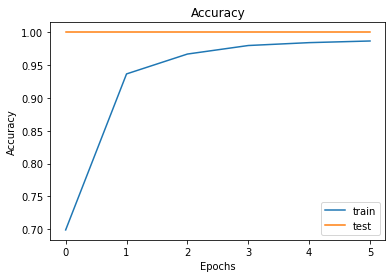

In [ ]:
#train accuracy
train_acc = history.history['accuracy']
#test accuracy
test_acc = history.history['val_accuracy']

plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
train = plt.plot(train_acc,label='train')
test = plt.plot(test_acc,label='test')
plt.legend()
plt.show()

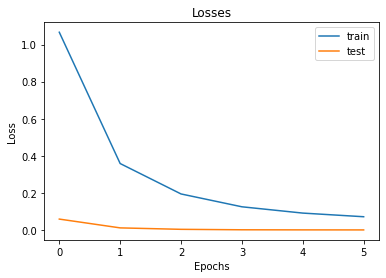

In [ ]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
train = plt.plot(train_loss,label='train')
test = plt.plot(test_loss,label='test')
plt.legend()
plt.show()


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100352)            401408    
_________________________________________________________________
dense (Dense)                (None, 256)               25690368  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1

In [ ]:
#save model
#model.save('/content/drive/MyDrive/ResNet Project/fingers.h5')
#load model
model = tf.keras.models.load_model(dataset_dir+'fingers.h5')

### Try Your Own Image & Get Prediction
* To try own image first we need to resize it
* then we need dark background like we have data in traing set


In [ ]:
#try own image

#load images
img1 = load_img(dataset_dir + "0R.jpg")
img2 = load_img(dataset_dir + "3L.jpg")

images = [img1,img2]
img_arr = []

#resize images
for ind,img in enumerate(images):
  images[ind] = img.resize((240,240))

#to set dark background
def blaken_image(img_arr,threshold=80):
  w ,h = img_arr.shape[0], img_arr.shape[1]
  #initialize with dark Image
  new_img = np.zeros((w,h,3))
  for i in range(w):
    for j in range(h):
      rgb = img_arr[i][j]
      #if redness is grater then it is hand
      if rgb[0] > threshold:
        new_img[i][j] = rgb
  return new_img

#apply blaken_image() on test images
black_images = []
for img in images:
  black_images.append(blaken_image(img_to_array(img)))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


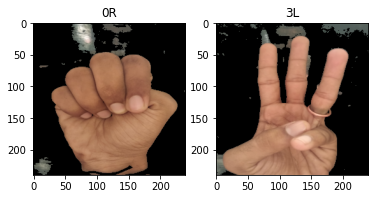

In [ ]:
#Make 2 Subplot
fig , axes = plt.subplots(1,2)

#make prediction
pred = model.predict_classes(asarray(black_images))
ind = 0
for ax,img in zip(axes,black_images):
  ax.imshow(array_to_img(img))
  ax.set_title(label_dict[pred[ind]])
  ind+=1


### Feature Insights using LIME
Now, let's take a look that which part of the image has more influence to get results.<br>
In order to do this task, I have used LIME(Local Interpretable Model-agnostic Explanations)[(Ribeiro et. al. 2016)](https://arxiv.org/abs/1602.04938) technique  which will give the area of an image that is more responsive to classify a particular class.<br>
You can see more about LIME [here](https://nbviewer.jupyter.org/url/arteagac.github.io/blog/lime_image.ipynb).

In [44]:
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression

dataset_dir = '/content/drive/MyDrive/ResNet Project/'

#load the model which we already trained in previous cells
resnet_model = tf.keras.models.load_model(dataset_dir+'fingers.h5')



In [45]:
def preprocess_data(x):
    x_p = keras.applications.resnet50.preprocess_input(x)
    return x_p

In [46]:
#to mask specific segments of images
def perturb_image(img,perturbation,segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    return perturbed_image

In [60]:
def get_insights(label,img_path,count=10,num_top_features = 6):
  images = os.listdir(img_path)
  print(len(images))
  c = 0
  originals = []
  insights = []
  for image in images:
    if label not in image:
      continue
    c+=1

    #Load Original Image 
    org = img_to_array(load_img(img_path+image))
    org = tf.image.resize(org,(224,224))
    org_image = array_to_img(org)
    originals.append(org_image)

    #ResNet50 Image Preprocessing
    Xi = img_to_array(load_img(img_path+image))
    Xi = tf.image.resize(Xi,(224,224))
    Xi = preprocess_data(Xi)
    plt.imshow(array_to_img(Xi))


    #make a prediction
    np.random.seed(222)   
    preds = resnet_model.predict(Xi[np.newaxis,:,:,:])
    top_pred_classes = preds[0].argsort()[-5:][::-1]
    print("Prediction:",label_dict[top_pred_classes[0]]) 

    #make a superpixels using quick shift algorithm
    superpixels = skimage.segmentation.quickshift(org, kernel_size=4,max_dist=200, ratio=0.1)
    num_superpixels = np.unique(superpixels).shape[0]

    #make a 150 perturbation with 50% hidden superpixels 
    num_perturb = 150
    perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))

    #make predictions of all 150 perturbations
    predictions = []
    for pert in perturbations:
      perturbed_img = perturb_image(Xi,pert,superpixels)
      pred = resnet_model.predict(perturbed_img[np.newaxis,:,:,:])
      predictions.append(pred)
    predictions = np.array(predictions)
  

    #initialize weights based on cosine distance
    original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
    distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
    kernel_width = 0.25
    weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
   
    #fit a LinearRegression model to get most affected superpixel 
    class_to_explain = top_pred_classes[0]
    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
    coeff = simpler_model.coef_[0]
   

    #set top-features you want to keep
    num_top_features = 6

    #make a image of only this 6 super pixel
    top_features = np.argsort(coeff)[-num_top_features:] 
    mask = np.zeros(num_superpixels) 
    mask[top_features]= True #Activate top superpixels
    img = array_to_img(perturb_image(org,mask,superpixels))
    insights.append(img)

    if c == count:
      return (insights,originals)
  return (insights,originals)

#to highlight most influincable area
def highlight(perturbed_image):
  perturbed_image = img_to_array(perturbed_image)
  w,h = perturbed_image.shape[0], perturbed_image.shape[1]
  for i in range(w):
    for j in range(h):
      rgb = perturbed_image[i][j]
      if sum(rgb)//3 > 130:
        perturbed_image[i][j][0] = 255
        perturbed_image[i][j][1] = 234
        perturbed_image[i][j][2] = 7
  return array_to_img(perturbed_image)

Let's try on 3 type of images:<br>


1.   1R - 1 finger of Right hand
2.   2R - 2 fingers of Right hand
3.   4L - 4 fingers of Left hand






372
Prediction: 1R
Prediction: 1R
Prediction: 1R
372
Prediction: 2R
Prediction: 2R
Prediction: 2R
372
Prediction: 4L
Prediction: 4L
Prediction: 4L


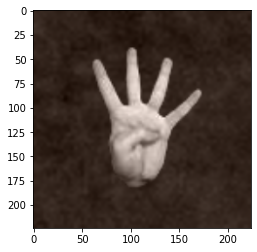

In [79]:
Test_path = dataset_dir + "Data/"
data = os.listdir(Test_path)
insights, original = [], []

i,o = get_insights("1R",Test_path,3)
insights.append(i)
original.append(o)

i,o = get_insights("2R",Test_path,3)
insights.append(i)
original.append(o)

i,o = get_insights("4L",Test_path,3,12)
insights.append(i)
original.append(o)

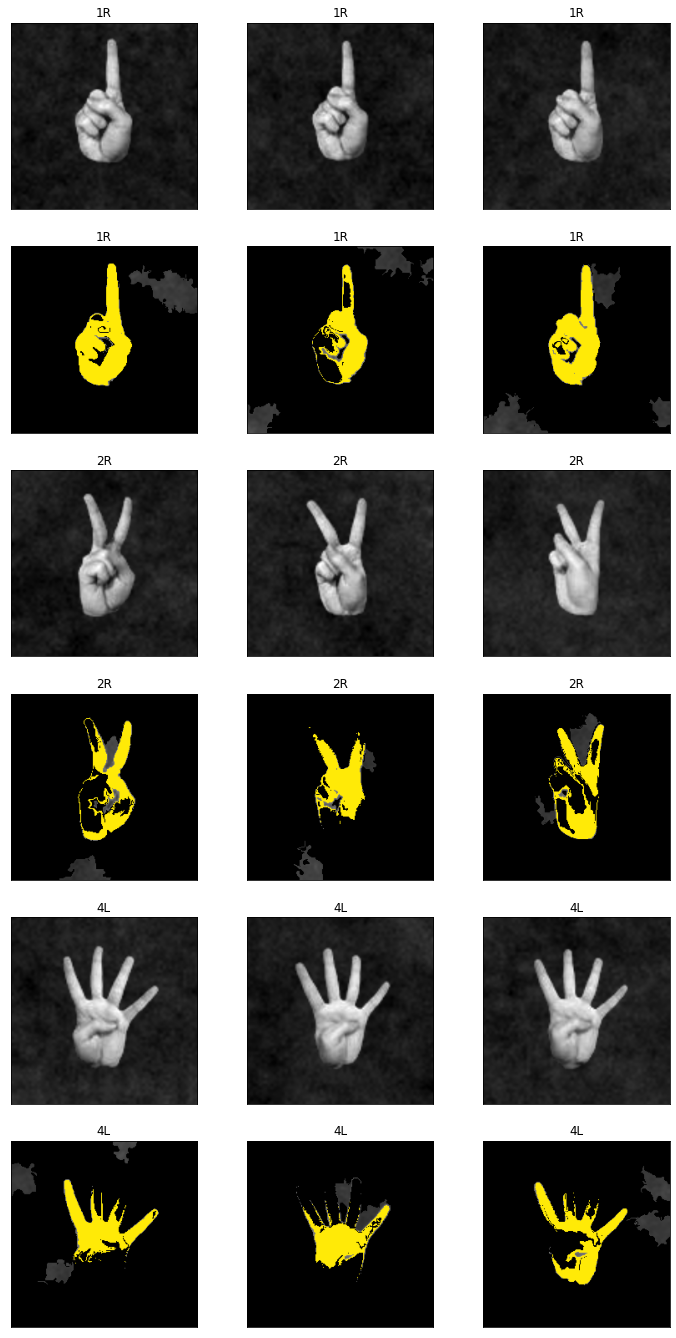

In [86]:
rows,cols = 6,3
labels = ["1R","2R","4L"]
fig,axes =  plt.subplots(rows,cols,figsize = (rows*2,24))
ind = 0
for i in range(rows):
  for j in range(cols):
    axes[i][j].set_title(labels[i//2])
    axes[i][j].get_xaxis().set_visible(False)
    axes[i][j].get_yaxis().set_visible(False)
    if i % 2 == 0:
      axes[i][j].imshow(original[i//2][j])
    else:
      axes[i][j].imshow(highlight(insights[i//2][j]))
    ind+=1

Yeahh! So you can see area of image which is mostly considered by model!